In [2]:
import os
import itk
import nrrd
import time
import pandas as pd
import random
import cv2 as cv
import numpy as np
import skimage as ski
import nibabel as nib
import SimpleITK as sitk
import scipy.ndimage as ndi
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
# paths to data
path_to_data         = "/usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ_BrainArtery"
path_to_results      = "/scratch-second/kvergopoulos/results"
path_to_process_data = "/scratch-second/kvergopoulos/processed_data"

In [3]:
def save_3D_img(save_path, img_T1):
    path_list = save_path.split('/')
    save_path = path_list[0:-1]
    save_path = "/".join(save_path)
    if os.path.exists(save_path) == False:
        os.makedirs(save_path)
    save_path = os.path.join(save_path, path_list[-1])
    sitk.WriteImage(img_T1, save_path)

In [7]:
# read a single nrrd file just to experiment with the threshold methods
path                = "/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated"
name_of_image       = "10745241-MCA-new/Segmentation-label.nrrd"
name_of_image_segm  = "10745241-MCA-new/Segmentation.nii"

mri_file_seg  = os.path.join(path, name_of_image_segm)
mri_file_init = os.path.join(path, name_of_image)
img_init, t   = nrrd.read(mri_file_init)
img_T1        = sitk.ReadImage(mri_file_init, sitk.sitkFloat64)
img_seg       = nib.load(mri_file_seg)
img_seg_data  = img_seg.get_fdata()

In [3]:
def get_data(path_to_data, path_to_process_data):
    test_list = list()
    data_dict = dict()
    entry       = 0
    total_entry = 0
    for mri_file in os.listdir(path_to_data):
        mri_file_path = os.path.join(path_to_data, mri_file)
        if os.path.isdir(mri_file_path) and not mri_file.startswith('.') and not mri_file.find("unlabelled") != -1:
            full_path_nii  = ""
            full_path_nrrd = ""
            processed_path_nrrd = ""
            for file in os.listdir(mri_file_path):
                if file.endswith(".nii") or file.endswith(".nii.gz"):
                    full_path_nii = os.path.join(mri_file_path, file)
                if file.endswith(".nrrd") and file.lower().find("tof") != -1:
                    full_path_nrrd = os.path.join(mri_file_path, file)
                    processed_path = full_path_nrrd.split("/")[-2:]
                    subject        = processed_path[0]
                    n4_path        = path_to_process_data + '/' + "/".join([processed_path[0],'n4_' + processed_path[1]])
                    hist_eq_path   = path_to_process_data + '/' + "/".join([processed_path[0],'he_' + processed_path[1]])
                    processed_path = path_to_process_data + '/' + processed_path[0]
            total_entry += 1
            if full_path_nii != "" and full_path_nrrd != "":
                entry += 1
                data_dict[entry] = {'name': subject, 'path':processed_path, 'nrrd': full_path_nrrd, 
                                    'nii': full_path_nii, 'pro_nrrd': hist_eq_path, 'n4':n4_path}
            else:
                print( mri_file)
    print(total_entry)
    return data_dict

dataset_dict     = get_data(path_to_data, path_to_process_data)

10147148-AComm-NEW
10600633-AComm-new-Colors
10107525-MCA-new-Colors
60213089-MCA-ICA-NEW
10015183-MCA-new
11096773_IB_PComm
10919238_GD_MCA
62


In [8]:
import dicom2nifti
def conv_dicom2nifti(path:str):
    assert os.path.isdir(path)
    head, tail = os.path.split(path)
    print(head)
    print(tail)
    if "tof" not in tail:
        tail = "tof_" + tail
    save_path = path 
    print(save_path)
    #dicom2nifti.convert_directory(new_path, save_path)
    print("Saving to: ",head)

path = '/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/10147148-AComm-NEW'
conv_dicom2nifti(path)


/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated
10147148-AComm-NEW
/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/10147148-AComm-NEW
Saving to:  /scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated


In [5]:
# preprocessing
# N-4 bias correction
def N4bias_correction_filter(img_init, image_mask_flag = True, shrinkFactor = 1, MaximumNumberOfIterations = None):
    '''
    following the official documentation:
    https://simpleitk.readthedocs.io/en/master/link_N4BiasFieldCorrection_docs.html
    '''
    image      = sitk.Cast(img_init, sitk.sitkFloat32)
    image_mask = None
    if image_mask_flag == True:
        image_mask = sitk.OtsuThreshold(image,0,1)
    
    if shrinkFactor > 1:
        image      = sitk.Shrink(img_init, [shrinkFactor] * img_init.GetDimension())
        if image_mask != None:
            image_mask = sitk.Shrink(image_mask, [shrinkFactor] * img_init.GetDimension()) 
        
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetNumberOfControlPoints([4,4,4])
    corrector.SetConvergenceThreshold(0.0001)
    if MaximumNumberOfIterations != None:
        corrector.SetMaximumNumberOfIterations(MaximumNumberOfIterations)
    
    if image_mask != None: corrected_image = corrector.Execute(image, image_mask)
    else: corrected_image = corrector.Execute(image)
    
    log_bias_field  = corrector.GetLogBiasFieldAsImage(img_init)
    log_bias_field  = sitk.Cast(log_bias_field, sitk.sitkFloat64)
    
    corrected_image_full = img_init / sitk.Exp(log_bias_field)
    return corrected_image_full, log_bias_field
    
# gaussian filter for denoising
def gaussian_filter(img_init):
    sigma         = 1
    img_init_sm_1 = ndi.gaussian_filter(img_init, sigma) 
    return img_init_sm_1

# median filter for denoising
def median_filter(img_init):
    img_init_sm_1 = np.empty_like(img_init)
    for slice in range(img_init.shape[-1]):
        img_init_sm_1[:,:,slice] = ndi.median_filter(img_init[:,:,slice], size = (3,3))
    return img_init_sm_1

# run n4 bias correction for all the images
time_4 = list()
time_2 = list()
time_1 = list()
for entry in dataset_dict:
    print(entry)
    img_T1  = sitk.ReadImage(dataset_dict[entry]['nrrd'], sitk.sitkFloat64)
    
    start = time.time()
    img_res1, log_bias1 = N4bias_correction_filter(img_T1, image_mask_flag = True, shrinkFactor = 4, MaximumNumberOfIterations = [200,100,70])
    end = time.time()
    time_4.append(end-start)
    print("end shrink = 4 with time ", end - start)
    
    start = time.time()
    img_res2, log_bias2 = N4bias_correction_filter(img_res1, image_mask_flag = True, shrinkFactor = 2, MaximumNumberOfIterations = [100,70,50])
    end = time.time()
    time_2.append(end-start)
    print("end shrink = 2 with time ", end - start)
    
    #start = time.time()
    #img_res3, log_bias3 = N4bias_correction_filter(img_res2, image_mask_flag = True, shrinkFactor = 1, MaximumNumberOfIterations = [30,20,10])
    #end = time.time()
    #time_1.append(end-start)
    #print("end shrink = 1 with time ", end - start)
    
    save_3D_img(dataset_dict[entry]['n4'], img_res2)

1
end shrink = 4 with time  59.50001621246338
end shrink = 2 with time  256.04368591308594
2
end shrink = 4 with time  71.66918683052063
end shrink = 2 with time  316.3722858428955
3
end shrink = 4 with time  78.31675624847412
end shrink = 2 with time  312.92952489852905
4
end shrink = 4 with time  58.93605422973633
end shrink = 2 with time  223.01719307899475
5
end shrink = 4 with time  73.03719973564148
end shrink = 2 with time  348.3766405582428
6
end shrink = 4 with time  64.5207588672638
end shrink = 2 with time  385.1091911792755
7
end shrink = 4 with time  38.97596979141235
end shrink = 2 with time  178.86355876922607
8
end shrink = 4 with time  75.78389883041382
end shrink = 2 with time  227.3612506389618
9
end shrink = 4 with time  63.68814015388489
end shrink = 2 with time  221.2290289402008
10
end shrink = 4 with time  36.12601280212402
end shrink = 2 with time  140.39897179603577
11
end shrink = 4 with time  65.5130684375763
end shrink = 2 with time  276.43098282814026
12
e

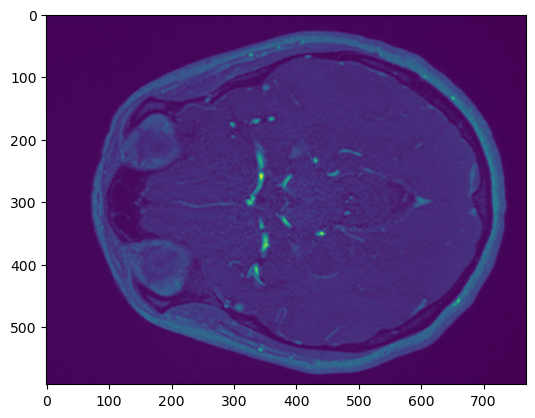

In [49]:
img_T1  = sitk.ReadImage(dataset_dict[entry]['nrrd'], sitk.sitkFloat64)
img_T1  = sitk.GetArrayFromImage(img_T1).T
plt.imshow(img_T1[:,:,114])

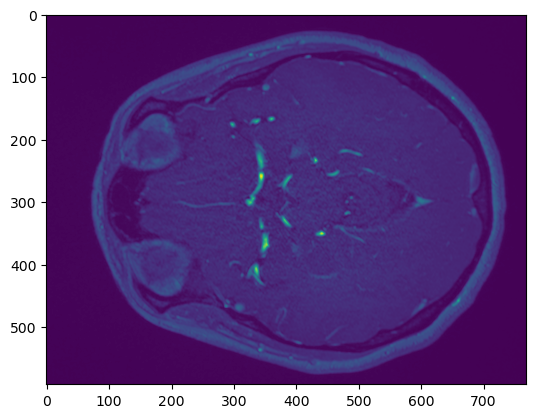

In [57]:
image_mtx = sitk.GetArrayFromImage(img_res2).T
plt.imshow(image_mtx[:,:,114])

In [8]:
log_bias_mtx = sitk.GetArrayFromImage(log_bias3)

(<matplotlib.image.AxesImage at 0x7f4d64287700>,
 <matplotlib.colorbar.Colorbar at 0x7f4d84a6f4c0>)

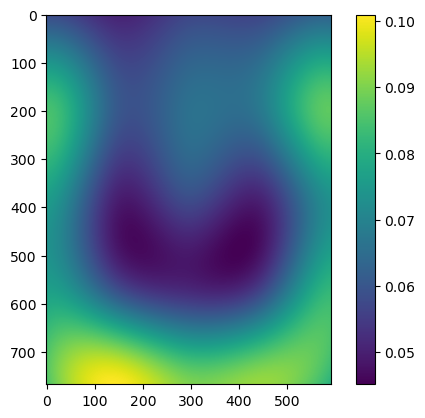

In [10]:
plt.imshow(log_bias_mtx[75,:,:]), plt.colorbar()

In [100]:
# random.seed(datetime.now().timestamp())
# reference_idx = random.randint(0, len(dataset_dict ))
# set the reference idx to be equal to the mri which achieves the best thresholding results
def histogram_matching(img_init, img_ref):
    return ski.exposure.match_histograms(img_init, img_ref)
    
reference_idx    = 23
mri_file_init    = dataset_dict[reference_idx]['nrrd']
img_init_ref, _  = nrrd.read(mri_file_init)

# equalize all the histograms based on the reference mri
for entry in dataset_dict:
    print(entry)
    mri_file_init       = dataset_dict[entry]['nrrd']
    img_T1              = sitk.ReadImage(dataset_dict[entry]['nrrd'])
    img_init            = sitk.GetArrayFromImage(img_T1)
    img_init            = img_init.T
    if entry == reference_idx:
        save_nrrd_image(path_to_process_data, img_init, img_T1, mri_file_init)
        continue
    matched             = histogram_matching(img_init, img_init_ref)
    matched_img         = sitk.GetImageFromArray(matched.T)
    matched_img.CopyInformation(img_T1)
    save_processed_file = save_3D_img(dataset_dict[entry]['pro_nrrd'], matched_img) 
    

1
/scratch-second/kvergopoulos/processed_data/10863077_KA_ICA/he_13 TOF_3D.nrrd
2
/scratch-second/kvergopoulos/processed_data/10986737_SH_PICA/he_17 TOF_3D_R5.nrrd
3
/scratch-second/kvergopoulos/processed_data/10764179-MCA-NEW_DONE/he_5 TOF_3D.nrrd
4
/scratch-second/kvergopoulos/processed_data/10102066_KA_AComm/he_501 TOF.nrrd
5
/scratch-second/kvergopoulos/processed_data/11050151_JT_PICA/he_8 TOF_3D_multi-slab.nrrd
6
/scratch-second/kvergopoulos/processed_data/10745241-MCA-new/he_6 TOF_3D.nrrd
7
/scratch-second/kvergopoulos/processed_data/10704331-AComm-NEW/he_11 3DTOF FS ASSET.nrrd
8
/scratch-second/kvergopoulos/processed_data/10788543_ZM_MirrorMCA/he_7 TOF_3D.nrrd
9
/scratch-second/kvergopoulos/processed_data/10599468-AComm-new/he_5 TOF_3D.nrrd
10
/scratch-second/kvergopoulos/processed_data/02053152-MCA-rechts-NEW/he_7 ax 3D TOF.nrrd
11
/scratch-second/kvergopoulos/processed_data/10820130_MB_MirrorMCA/he_501 TOF.nrrd
12
/scratch-second/kvergopoulos/processed_data/10799172_WH_MCA/he_

In [ ]:
def histogram_back_fore_ground(image_init, segmentation_mask, name, path, type_of):
    
    # avoid np.unique use sets
    all_values = np.unique(image_init)
    
    image_fg = np.where(segmentation_mask > 0, image_init, -1)
    image_bg = np.where(segmentation_mask > 0, -1, image_init)
    
    unique_fg, counts_fg = np.unique(image_fg, return_counts=True)
    unique_fg = unique_fg[1:]
    counts_fg = counts_fg[1:]
    unique_bg, counts_bg = np.unique(image_bg, return_counts=True)
    unique_bg = unique_bg[1:]
    counts_bg = counts_bg[1:]
    
    x_axis  = [i for i in all_values]
    fg_vals = np.zeros(len(x_axis))
    bg_vals = np.zeros(len(x_axis))
    counter = 0
    for idx, val in enumerate(x_axis):
        t_fg = np.where(unique_fg == val)
        t_bg = np.where(unique_bg == val)
        if t_fg[0].size != 0: fg_vals[idx] = counts_fg[t_fg]
        if t_bg[0].size != 0: bg_vals[idx] = counts_bg[t_bg]
    fig = plt.figure()
    plt.title('hgram of fore/background in log10:' + name)
    plt.plot(x_axis, fg_vals, 'r', label = 'foreground intensities')
    plt.plot(x_axis, bg_vals, 'b', label = 'background intensities')
    plt.xlabel("intensities")
    plt.ylabel("pixels in log10")
    plt.yscale('log')
    plt.legend(loc='upper right')
    plt.show()
    fig.savefig(path + '/' + name + '_' + type_of + '.png')

# run all the plots to decide which one to take for reference
for t in dataset_dict:
    print(t)
    mri_file_seg  = dataset_dict[t]['nii']
    mri_file_init = dataset_dict[t]['nrrd']
    img_init, _   = nrrd.read(mri_file_init)
    img_seg       = nib.load(mri_file_seg)
    img_seg_data  = img_seg.get_fdata()
    histogram_back_fore_ground(img_init, img_seg_data, dataset_dict[t]['name'], dataset_dict[t]['path'], 'simple')

### Global thresholding

In [4]:
def binarize(image, threshold = 0):
    mask = image >= threshold
    return mask

def dice_metric(pred_mask, gt_mask):
    vol_sum   = pred_mask.sum() + gt_mask.sum()
    if vol_sum == 0:
        return np.Nan
    vol_intersect = (pred_mask & gt_mask).sum()
    return 2*vol_intersect/vol_sum

def recall_metric(pred_mask, gt_mask):
    TP = np.sum(np.logical_and(pred_mask==True, gt_mask == True))
    FN = np.sum(np.logical_and(pred_mask == False, gt_mask == True))
    return TP/(FN+TP)

In [5]:
def global_thresholding(img, threshold = 0):
    mask = np.where(img < threshold, 0, img)
    return mask

In [8]:
# global thresholding all the dataset print stats and save images
save_path = path_to_results + '/' + "thresholded_images_" + "global_thresholding"
if os.path.exists(save_path) == False:
    os.makedirs(save_path)

percent     = 98.5
recall_list = list()
dice_list   = list()
typeof      = 'nrrd'
for t in dataset_dict:
    print(t)
    img_T1        = sitk.ReadImage(dataset_dict[t][typeof])
    img_init      = sitk.GetArrayFromImage(img_T1)
    img_init      = img_init.T
    
    mri_file_seg  = dataset_dict[t]['nii']
    img_seg       = nib.load(mri_file_seg)
    img_seg_data  = img_seg.get_fdata()
    print(img_init.shape, img_seg_data.shape)
    
    threshold     = np.percentile(img_init, percent)
    img_mask      = global_thresholding(img_init, threshold)
    img_mask_bin  = binarize(img_mask, threshold)
    gt_mask_bin   = binarize(img_seg_data, 1)
    dice_list.append(dice_metric(img_mask_bin, gt_mask_bin))
    recall_list.append(recall_metric(img_mask_bin, gt_mask_bin))
    
    img_mask_sitk = sitk.GetImageFromArray(img_mask.T)
    img_mask_sitk.CopyInformation(img_T1)
    file_name = dataset_dict[t]['name'] + '_' + str(percent) + '_' + typeof
    print(file_name)
    
    # save image as nii.gz file
    sitk.WriteImage(img_mask_sitk, os.path.join(save_path, file_name + ".nii.gz"))

1
(592, 768, 150) (592, 768, 150)
10863077_KA_ICA_98.5_nrrd
2
(532, 640, 207) (532, 640, 207)
10986737_SH_PICA_98.5_nrrd
3
(560, 640, 190) (560, 640, 190)
10764179-MCA-NEW_DONE_98.5_nrrd
4
(640, 640, 200) (640, 640, 200)
10102066_KA_AComm_98.5_nrrd
5
(696, 768, 139) (696, 768, 139)
11050151_JT_PICA_98.5_nrrd
6
(560, 640, 200) (560, 640, 200)
10745241-MCA-new_98.5_nrrd
7
(512, 512, 144) (512, 512, 144)
10704331-AComm-NEW_98.5_nrrd
8
(560, 640, 190) (560, 640, 190)
10788543_ZM_MirrorMCA_98.5_nrrd
9
(560, 640, 200) (560, 640, 200)
10599468-AComm-new_98.5_nrrd
10
(512, 512, 112) (512, 512, 112)
02053152-MCA-rechts-NEW_98.5_nrrd
11
(640, 640, 200) (640, 640, 200)
10820130_MB_MirrorMCA_98.5_nrrd
12
(672, 672, 140) (672, 672, 140)
10799172_WH_MCA_98.5_nrrd
13
(560, 640, 200) (560, 640, 200)
10083905_GLUK_MCA_98.5_nrrd
14
(696, 768, 152) (696, 768, 152)
10731124-MCA-rechts-NEW_98.5_nrrd
15
(560, 640, 200) (560, 640, 200)
07767625_LJ_Pericallosa_98.5_nrrd
16
(520, 640, 284) (520, 640, 284)
0548

In [9]:
print(np.mean(dice_list),np.std(dice_list), np.min(dice_list), np.max(dice_list))
print(np.mean(recall_list), np.std(recall_list), np.min(recall_list), np.max(recall_list))

0.26076387068252915 0.05156548433612711 0.18452933678139113 0.40109108076445593
0.8604586311031965 0.060540138249102746 0.661084448683936 0.9667523384451558


In [12]:
# global thresholding 3D image
number       = 1
percent      = 99.7
typeof       = 'n4'
img_init, _  = nrrd.read(dataset_dict[number][typeof])
img_seg      = nib.load(dataset_dict[number]['nii'])
img_seg_data = img_seg.get_fdata()

threshold    = np.percentile(img_init, percent)
img_mask     = global_thresholding(img_init, threshold)
img_mask_bin = binarize(img_mask, threshold)
gt_mask_bin  = binarize(img_seg_data, 1)
print(dice_metric(img_mask_bin, gt_mask_bin), recall_metric(img_mask_bin, gt_mask_bin))

0.6912992593382599 0.811801696691649


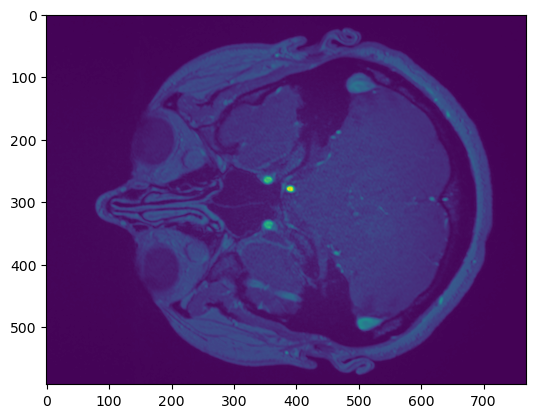

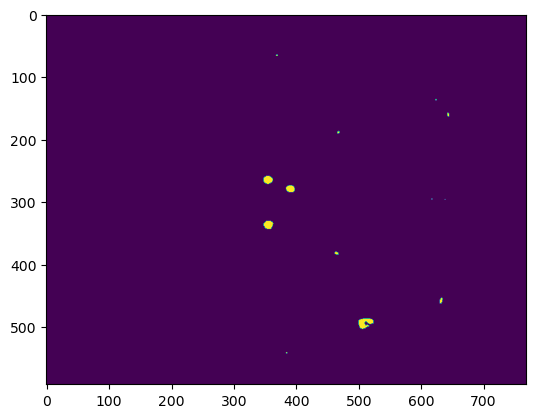

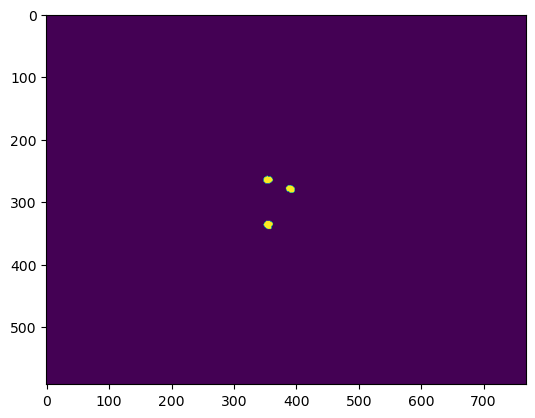

In [13]:
slice = 75
plt.figure()
plt.imshow(img_init[:,:,slice])
plt.figure()
plt.imshow(img_mask_bin[:,:,slice])
plt.figure()
plt.imshow(gt_mask_bin[:,:,slice])

In [13]:
# thresholding each slice of the 3D image
img_mask2 = np.zeros(img_init.shape, dtype=bool)
for slice in range(img_init.shape[-1]):
    threshold      = np.percentile(img_init[:, :, slice], 99)
    img_mask_slice = global_thresholding(img_init[:, :, slice], threshold) 
    img_mask2[:, :, slice] = binarize(img_mask_slice, threshold)
print(dice_metric(img_mask2, binarize(img_seg_data,1)))

0.34166475422687065


In [14]:
# thresholding each slice of the 3D smoothed image
img_mask2 = np.zeros(img_init_sm_1.shape, dtype=bool)
for slice in range(img_init_sm_1.shape[-1]):
    threshold      = np.percentile(img_init_sm_1[:, :, slice], 99)
    img_mask_slice = global_thresholding(img_init_sm_1[:, :, slice], threshold) 
    img_mask2[:, :, slice] = binarize(img_mask_slice, threshold)
print(dice_metric(img_mask2, binarize(img_seg_data,1)))

0.34084101271503875


In [ ]:
slice = 1
plt.figure()
plt.imshow(img_init[:,:,slice])
plt.figure()
plt.imshow(img_mask[:,:,slice])
plt.figure()
plt.imshow(img_seg_data[:,:,slice])

In [117]:
# split train/valid set
split_flag = True

if split_flag == True:
    valid_size     = int(0.2*len(dataset_dict))
    validation_set = random.sample([key for key in dataset_dict], valid_size)
    training_set   = [key for key in dataset_dict if key not in validation_set]
print(validation_set)

[1, 13, 41, 47, 25, 51, 12, 20, 9, 29, 39]


In [95]:
def validate_threshold(validation_set, global_threshold):
    recall_list = list()
    dice_list   = list()
    for t in validation_set:
        print(t)
        # read files
        mri_file_init = dataset_dict[t]['pro_nrrd']
        mri_file_seg  = dataset_dict[t]['nii']
        img_init, _   = nrrd.read(mri_file_init)
        img_seg       = nib.load(mri_file_seg).get_fdata()
        # compute ground truth mask
        gt_mask_bin   = binarize(img_seg, 1)
        
        img_mask_pred  = global_thresholding(img_init, global_threshold)
        img_mask_bin   = binarize(img_mask_pred, global_threshold)
        dice           = dice_metric(img_mask_bin, gt_mask_bin)
        recall         = recall_metric(img_mask_bin, gt_mask_bin)
        recall_list.append(recall)
        dice_list.append(dice)
        plt.figure()
        plt.imshow(img_init[:,:,110])
        plt.figure()
        plt.imshow(img_mask_bin[:,:,110])
        plt.figure()
        plt.imshow(gt_mask_bin[:,:,110])
        print(t, dice, recall)
    print("recall", np.mean(recall_list), np.max(recall_list), np.min(recall_list))
    print("dice", np.mean(dice_list), np.max(dice_list), np.min(dice_list))
    return dice_list, recall_list
    
def find_threshold_for_max_recall(img, gt_mask_bin, recall_threshold_range):
    # initialize threshold to be the minimum value of the foreground intensities.
    image_fg         = np.where(gt_mask_bin > 0, img, -1)
    unique_fg        = np.unique(image_fg)
    all_thresholds   = unique_fg[1:]
    valid_thresholds = list()
    metrics          = list()
    for t_threshold in all_thresholds:
        img_mask       = global_thresholding(img, t_threshold)
        img_mask_bin   = binarize(img_mask, t_threshold)
        dice           = dice_metric(img_mask_bin, gt_mask_bin)
        recall         = recall_metric(img_mask_bin, gt_mask_bin)
        if recall < recall_threshold_range: break
        metrics.append((recall, dice))
        valid_thresholds.append(t_threshold)
    return metrics, valid_thresholds

def binary_search(arr, l, r, x, visited, img, gt_mask_bin):
    if r >= l: 
        mid = l + (r-l)//2
        
        img_mask = global_thresholding(img, arr[mid])
        t_recall = recall_metric(binarize(img_mask, arr[mid]), gt_mask_bin)
        visited.append((arr[mid], t_recall))
        #print(t_recall)
        if t_recall == x:
            return 1
        elif t_recall < x:
            return binary_search(arr, l, mid-1, x, visited, img, gt_mask_bin)
        else:
            return binary_search(arr, mid+1, r, x, visited, img, gt_mask_bin)
    else:
        return -1
    
def find_threshold_for_max_recall_fast(img, gt_mask_bin, recall_threshold_range):
    # initialize threshold to be the minimum value of the foreground intensities.
    image_fg         = np.where(gt_mask_bin > 0, img, -1)
    unique_fg        = np.unique(image_fg)
    all_thresholds   = unique_fg[1:]
    visited          = []
    _                = binary_search(all_thresholds, 0, len(all_thresholds)-1, recall_threshold_range, visited, img, gt_mask_bin)
    threshold_range  = (unique_fg[1] ,visited[-1][0])
    
    first_recall     = recall_metric(binarize(global_thresholding(img, unique_fg[1]), unique_fg[1]), gt_mask_bin)
    recall_metrics   = (first_recall, visited[-1][1])
    return threshold_range, recall_metrics

def save_thresholding_logs(log_dict, path_to_results,recall_threshold_range):
    file_name = 'training_thresholind_' + str(recall_threshold_range) + '.txt'
    file_path = os.path.join(path_to_results, file_name)
    with open(file_path, 'a') as t:
        for key in log_dict:
            log_line = f"key:{key}, min:{log_dict[key]['min']}, max:{log_dict[key]['max']}, center:{log_dict[key]['center']}, recall_range:{log_dict[key]['metrics'][0]}-{log_dict[key]['metrics'][1]}\n"
            t.write(log_line)

# for reproductive reasons keep the same validation set
if split_flag == True:
    validation_set = [1, 13, 41, 47, 25, 51, 12, 20, 9, 29, 39]
    training_set   = [key for key in dataset_dict if key not in validation_set]
else:
    training_set = [key for key in dataset_dict]

recall_threshold_range = 0.95
train_log_dict         = dict()
for t in training_set:
    print(t)
    # read files
    mri_file_init = dataset_dict[t]['pro_nrrd']
    mri_file_seg  = dataset_dict[t]['nii']
    img_init, _   = nrrd.read(mri_file_init)
    img_seg       = nib.load(mri_file_seg).get_fdata()
    # compute ground truth mask
    gt_mask_bin                = binarize(img_seg, 1)
    thresholds, recall_metrics = find_threshold_for_max_recall_fast(img_init, gt_mask_bin, recall_threshold_range)  
    # find the best threshold value
    #metrics, thresholds = find_threshold_for_max_recall(img_init, gt_mask_bin, recall_threshold_range)
    train_log_dict[t] = {'thresholds':thresholds, 'min':np.min(thresholds), 'max':np.max(thresholds), 'center': (thresholds[0] + thresholds[1])/2 , 'metrics': recall_metrics}
    
save_thresholding_logs(train_log_dict, path_to_results,recall_threshold_range)
lower_left_bound  = [train_log_dict[t]['min'] for t in train_log_dict]
upper_right_bound = [train_log_dict[t]['max'] for t in train_log_dict]
centers           = [train_log_dict[t]['center'] for t in train_log_dict]
final_threshold   = np.mean(centers)

#valid_dice_list, valid_recall_list = validate_threshold(validation_set, final_threshold)

2
3
4
5
6
7
8
10
11
14
15
16
17
18
19
21
22
23
24
26
27
28
30
31
32
33
34
35
36
37
38
40
42
43
44
45
46
48
49
50
52
53
54
55


In [ ]:
final_threshold = 88.8
validate_threshold(validation_set, final_threshold)

### Apply local adaptive filters from the library simple itk


In [6]:
mri_file_seg  = os.path.join(path, name_of_image_segm)
mri_file_init = os.path.join(path, name_of_image)
img_init, _   = nrrd.read(mri_file_init)
img_seg       = nib.load(mri_file_seg)
img_seg_data  = img_seg.get_fdata() 
img_T1        = sitk.GetImageFromArray(img_init)

In [17]:
# second smoothed version of the initial image
sigma         = 1
img_init_sm_1 = ndi.gaussian_filter(img_init, sigma)
img_T1_sm_1   = sitk.GetImageFromArray(img_init_sm_1)

In [144]:
# apply median filter for denoising
img_init_sm_1 = np.empty_like(img_init)
for slice in range(img_init.shape[-1]):
    img_init_sm_1[:,:,slice] = ndi.median_filter(img_init[:,:,slice], size = (3,3))
img_T1_sm_1   = sitk.GetImageFromArray(img_init_sm_1)

In [18]:
# otsu threshold in the 3D image
filter_  = sitk.OtsuThreshold(img_T1, 0, 1, 256)
img_otsu = sitk.GetArrayFromImage(filter_) 
print(dice_metric(binarize(img_otsu,1), binarize(img_seg_data,1)))

0.010162353544385213


In [146]:
# otsu threshold in the 3D smoothed image
filter_  = sitk.OtsuThreshold(img_T1_sm_1, 0, 1, 256)
img_otsu = sitk.GetArrayFromImage(filter_) 
print(dice_metric(binarize(img_otsu,1), binarize(img_seg_data,1)))

0.009861079816985053


In [60]:
# Yen threshold in the 3D image
filter_  = sitk.YenThreshold(img_T1, 0, 1, 256)
img_yen = sitk.GetArrayFromImage(filter_) 
print(dice_metric(binarize(img_yen, 1), binarize(img_seg_data,1)), recall_metric(binarize(img_yen, 1), binarize(img_seg_data,1)))

0.6042490513133727 0.5391647664893168


In [ ]:
# Yen threshold in the 3D smoothed image
filter_  = sitk.YenThreshold(img_T1_sm_1, 0, 1, 256)
img_yen  = sitk.GetArrayFromImage(filter_) 
print(dice_metric(binarize(img_yen,1), binarize(img_seg_data,1)))

In [63]:
# Maximum entropy threshold in the 3D image
filter_  = sitk.MaximumEntropyThreshold(img_T1, 0, 1, 256)
img_yen  = sitk.GetArrayFromImage(filter_) 
print(dice_metric(binarize(img_yen,1), binarize(img_seg_data,1)))
print(recall_metric(binarize(img_yen,1), binarize(img_seg_data,1)))

0.6112081159932808
0.5838506038341357


In [150]:
# Maximum entropy threshold in the 3D smoothed image
filter_  = sitk.MaximumEntropyThreshold(img_T1_sm_1, 0, 1, 50)
img_yen  = sitk.GetArrayFromImage(filter_) 
print(dice_metric(binarize(img_yen,1), binarize(img_seg_data,1)))

0.6098228439846797


In [151]:
# Reny entropy threshold in the 3D image
filter_  = sitk.RenyiEntropyThreshold(img_T1, 0, 1, 256)
img_yen  = sitk.GetArrayFromImage(filter_) 
print(dice_metric(binarize(img_yen,1), binarize(img_seg_data,1)))

0.6112081159932808


In [152]:
# Reny entropy threshold in the 3D smoothed image
filter_  = sitk.RenyiEntropyThreshold(img_T1_sm_1, 0, 1, 256)
img_yen  = sitk.GetArrayFromImage(filter_) 
print(dice_metric(binarize(img_yen,1), binarize(img_seg_data,1)))

0.6110838057790783


In [153]:
# Huang entropy threshold in the 3D image
filter_  = sitk.HuangThreshold(img_T1, 0, 1, 256)
img_yen  = sitk.GetArrayFromImage(filter_) 
print(dice_metric(binarize(img_yen,1), binarize(img_seg_data,1)))

0.008934108256999352


In [154]:
# IsoData threshold in the 3D image
filter_  = sitk.IsoDataThreshold(img_T1, 0, 1, 256)
img_yen  = sitk.GetArrayFromImage(filter_) 
print(dice_metric(binarize(img_yen,1), binarize(img_seg_data,1)))

0.010302478264022825


In [155]:
# KittlerIllingworth Threshold in the 3D smoothed image
filter_  = sitk.KittlerIllingworthThreshold(img_T1, 0, 1, 256)
img_yen  = sitk.GetArrayFromImage(filter_) 
print(dice_metric(binarize(img_yen,1), binarize(img_seg_data,1)))

0.007975583070013066


In [156]:
# Triangle Threshold in the 3D smoothed image
filter_  = sitk.TriangleThreshold(img_T1, 0, 1, 256)
img_yen  = sitk.GetArrayFromImage(filter_) 
print(dice_metric(binarize(img_yen,1), binarize(img_seg_data,1)))

0.008262306412226618


In [157]:
# Shanbhag Threshold in the 3D smoothed image
filter_  = sitk.ShanbhagThreshold(img_T1, 0, 1, 53)
img_yen  = sitk.GetArrayFromImage(filter_) 
print(dice_metric(binarize(img_yen,1), binarize(img_seg_data,1)))

0.09959525947027639


In [158]:
# Intermodes Threshold in the 3D smoothed image
filter_  = sitk.IntermodesThreshold(img_T1, 0, 1, 256)
img_yen  = sitk.GetArrayFromImage(filter_) 
print(dice_metric(binarize(img_yen,1), binarize(img_seg_data,1)))

0.009763595432252973


In [159]:
filter_  = sitk.ScalarConnectedComponent(img_T1, 30)
img_     = sitk.GetArrayFromImage(filter_)
img_mask = binarize(img_, 2)
gt_mask  = binarize(img_seg_data, 1)
print(dice_metric(img_mask, gt_mask))

0.10318037998187733


In [160]:
filter_ = sitk.MomentsThresholdImageFilter()
filter_.SetInsideValue(0)
filter_.SetOutsideValue(1)
filter_.SetNumberOfHistogramBins(255)
img_    = sitk.GetArrayFromImage(filter_.Execute(img_T1))
print(dice_metric(img_, binarize(img_seg_data, 1)))

0.01727065509934124


In [161]:
# Li threshold in the 3D image
filter_ = sitk.LiThreshold(img_T1, 0, 1, 255)
img_    = sitk.GetArrayFromImage(filter_)
print(dice_metric(img_, binarize(img_seg_data, 1)))

0.008934108256999352


In [14]:
def yen_threshold(img_T1, img_seg):
    filter_  = sitk.YenThreshold(img_T1, 0, 1, 256)
    img_res  = sitk.GetArrayFromImage(filter_) 
    img_res  = img_res.T
    return dice_metric(binarize(img_res,1), binarize(img_seg,1)), recall_metric(binarize(img_res,1), binarize(img_seg,1)), filter_, None
    
def maximumentropy_threshold(img_T1, img_seg):
    filter_  = sitk.MaximumEntropyThreshold(img_T1, 0, 1, 256)
    img_res  = sitk.GetArrayFromImage(filter_) 
    img_res   = img_res.T
    return dice_metric(binarize(img_res, 1), binarize(img_seg, 1)), recall_metric(binarize(img_res, 1), binarize(img_seg, 1)), filter_, None
    
def renyientropy_threshold(img_T1, img_seg):
    filter_  = sitk.RenyiEntropyThreshold(img_T1, 0, 1, 256)
    img_res  = sitk.GetArrayFromImage(filter_) 
    img_res   = img_res.T
    return dice_metric(binarize(img_res, 1), binarize(img_seg, 1)), recall_metric(binarize(img_res, 1), binarize(img_seg, 1)),  filter_, None

def frangi_filter(mri_file_init, img_seg):
    input_image       = itk.imread(mri_file_init, itk.ctype("float"))
    hessian_image     = itk.hessian_recursive_gaussian_image_filter(input_image, sigma = 1.0)
    vesselness_filter = itk.Hessian3DToVesselnessMeasureImageFilter[itk.ctype("float")].New()
    vesselness_filter.SetInput(hessian_image)
    vesselness_filter.SetAlpha1(0.5)
    vesselness_filter.SetAlpha2(2.0)
    
    img_mask     = vesselness_filter.GetOutput()
    img_mask     = itk.array_from_image(img_mask)
    img_mask     = img_mask.T
    img_mask_bin = binarize(img_mask,1)
    return dice_metric(img_mask_bin, binarize(img_seg,1)), recall_metric(img_mask_bin, binarize(img_seg,1)), None, img_mask

In [15]:
def compute_thresholds(dataset_dict, which_thresholds,typeof):
    dice_metric_dict   = defaultdict(list)
    recall_metric_dict = defaultdict(list)
    for entry in dataset_dict:
        print(entry)
        img_T1      = sitk.ReadImage(dataset_dict[entry][typeof])
        img_seg     = nib.load(dataset_dict[entry]['nii']).get_fdata()
        
        for threshold_method in which_thresholds:
            if threshold_method == 'Yen':
                dice_measure, recall_measure, f_, _ = yen_threshold(img_T1, img_seg)
            elif threshold_method == 'Maximum':
                dice_measure, recall_measure, f_, _ = maximumentropy_threshold(img_T1, img_seg)
            elif threshold_method == 'Renyi':
                dice_measure, recall_measure, f_, _ = renyientropy_threshold(img_T1, img_seg)
            elif threshold_method == 'Frangi':
                dice_measure, recall_measure, f_, img_mask = frangi_filter(dataset_dict[entry][typeof], img_seg)
            else:
                print("no threshold method named", threshold_method)
                continue
            print(dice_measure, recall_measure, threshold_method)
            dice_metric_dict[threshold_method].append(dice_measure)
            recall_metric_dict[threshold_method].append(recall_measure)
            if f_ != None:
                save_logs(threshold_method, f_, dice_measure, dataset_dict[entry][typeof], path_to_results)
    return dice_metric_dict, recall_metric_dict

def save_logs(threshold_method, f_, dice_measure, file_name, path_to_results):
    '''
    save resulted images
    '''
    save_path = os.path.join(path_to_results, "thresholded_images_" + threshold_method + '_n4')
    if os.path.exists(save_path) == False: os.makedirs(save_path)
    file_name = file_name.split("/")[-2]
    file_name = file_name + "_" + str(dice_measure)
    # save images as nii.gz 
    sitk.WriteImage(f_, os.path.join(save_path, file_name + ".nii.gz"))   
    
which_thresholds             = ['Yen','Maximum','Renyi','Frangi']
results_dice, results_recall = compute_thresholds(dataset_dict, which_thresholds, typeof = 'n4')

1
0.666167091577001 0.539104985267654 Yen
0.7090405045863025 0.6280000263666146 Maximum
0.7233603953406283 0.6754071994041145 Renyi
0.02967762947027543 0.890789482357439 Frangi
2
0.5382776994201536 0.44011839854436424 Yen
0.5850312013314469 0.5258676473414786 Maximum
0.5953028395774363 0.548413344182262 Renyi
0.07524294135936099 0.7899771275539297 Frangi
3
0.6649486720862614 0.5533280663638159 Yen
0.6788905023258104 0.5837307073728168 Maximum
0.6819575662689629 0.5940342164912578 Renyi
0.03784341560674504 0.801444654496205 Frangi
4
0.6744822771494314 0.5957164788885999 Yen
0.6904251654266195 0.6473058111928591 Maximum
0.6935583210661728 0.6660053187473259 Renyi
0.02134461214645872 0.8032692678752695 Frangi
5
0.529969735914763 0.3800488759134504 Yen
0.5666072861813127 0.4302507417603653 Maximum
0.5853010246845527 0.46088440430250743 Renyi
0.039081056734458365 0.8223699466646054 Frangi
6
0.6482795045169532 0.5571742251499029 Yen
0.6667439071723602 0.6074972552993835 Maximum
0.67015060767

0.6766884481550811 0.6130030637669248 Renyi
0.047336002052893025 0.7935260368172196 Frangi
47
0.720183954646708 0.6608182061096517 Yen
0.7450450607492112 0.7416012242900818 Maximum
0.7468311100790395 0.753337474450579 Renyi
0.04152282509871809 0.858998427994878 Frangi
48
0.6714151137379795 0.599369071707263 Yen
0.6921096587685652 0.6535699954750744 Maximum
0.6921096587685652 0.6535699954750744 Renyi
0.049404850825147624 0.7482391209691878 Frangi
49
0.6245207878349414 0.4856307637304283 Yen
0.6541573265311381 0.5339383169118498 Maximum
0.664440251572327 0.5554527387249077 Renyi
0.0686968986554505 0.7430572350918516 Frangi
50
0.7770613409415121 0.7369512866071992 Yen
0.7771522786689622 0.7694840042210457 Maximum
0.7752228579628002 0.7796487873512938 Renyi
0.01961270369190361 0.910555320050869 Frangi
51
0.6021876367272955 0.4812531844111212 Yen
0.6506677388781987 0.5658411340999231 Maximum
0.6561668472741509 0.577709621666983 Renyi
0.0336354856030924 0.7803730381529916 Frangi
52
0.7085267

In [19]:
print(np.mean(results_dice['Maximum']))
print(np.max(results_dice['Maximum']))
print(np.min(results_dice['Maximum']))
print(np.std(results_dice['Maximum']))

0.6837881610099669
0.7868928240060491
0.5270386367460934
0.05893296928124371


In [66]:
# local thresholding 3D image maximum, yen, renyi
number       = 5
typeof       = 'nrrd'

img_T1       = sitk.ReadImage(dataset_dict[number][typeof])
img_init, _  = nrrd.read(dataset_dict[number][typeof])
img_seg      = nib.load(dataset_dict[number]['nii']).get_fdata()
gt_mask_bin  = binarize(img_seg, 1)

dice_measure, recall_measure, f_,_ = maximumentropy_threshold(img_T1, img_seg)
print(dice_measure, recall_measure)

img_mask_bin = sitk.GetArrayFromImage(f_).T 
img_mask_bin = binarize(img_mask_bin, 1)


0.587898421666769 0.45535464767125894


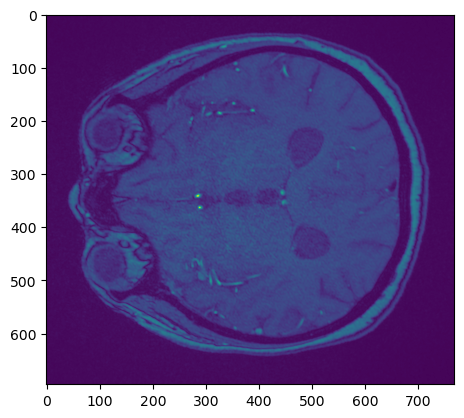

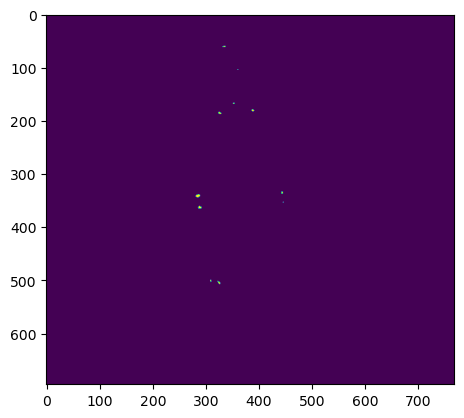

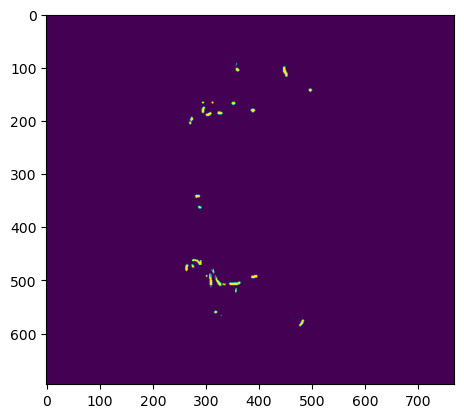

In [70]:
slice =100
plt.figure()
plt.imshow(img_init[:,:,slice])
plt.figure()
plt.imshow(img_mask_bin[:,:,slice])
plt.figure()
plt.imshow(gt_mask_bin[:,:,slice])

In [89]:
# local thresholding 3D image frangi
number       = 27
typeof       = 'nrrd'

img_T1       = sitk.ReadImage(dataset_dict[number][typeof])
img_init, _  = nrrd.read(dataset_dict[number][typeof])
img_seg      = nib.load(dataset_dict[number]['nii']).get_fdata()
gt_mask_bin  = binarize(img_seg, 1)

dice_measure, recall_measure, _, img_mask = frangi_filter(dataset_dict[number][typeof], img_seg)
img_mask_bin = binarize(img_mask,1)
print(dice_measure, recall_measure)

0.023707189109082503 0.7800073956804604


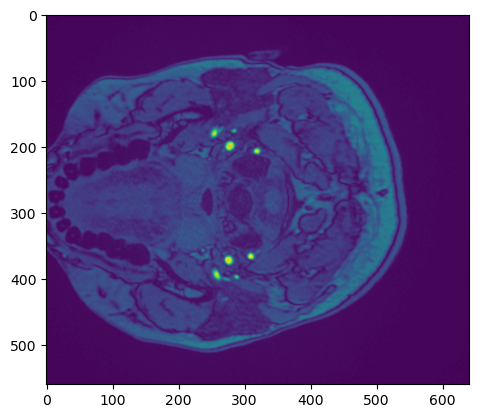

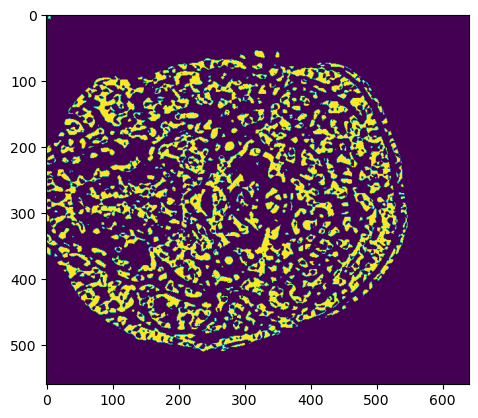

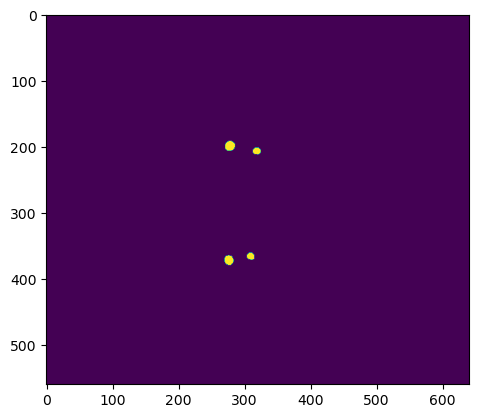

In [90]:
slice = 5
plt.figure()
plt.imshow(img_init[:,:,slice])
plt.figure()
plt.imshow(img_mask_bin[:,:,slice])
plt.figure()
plt.imshow(gt_mask_bin[:,:,slice])

In [31]:
for key in dataset_dict:
    if dataset_dict[key]['name']=='10799172_WH_MCA':
        print(key)
    

12


In [34]:
path_to_mask = '/scratch-second/kvergopoulos/results/thresholded_images_Yen_n4'
file_name    = '10799172_WH_MCA_0.7012793969315708.nii.gz'
img_seg_gt   = nib.load(dataset_dict[12]['nii']).get_fdata()
img_seg_pr   = nib.load(path_to_mask + '/' + file_name).get_fdata()

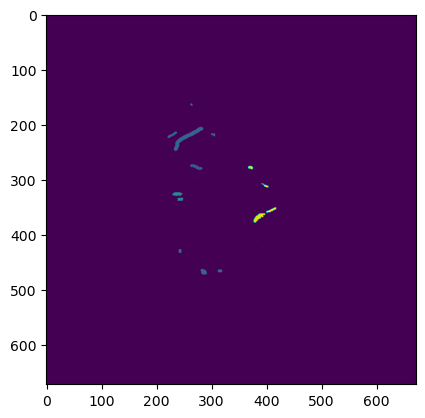

In [35]:
plt.imshow(img_seg_gt[:,:,117])

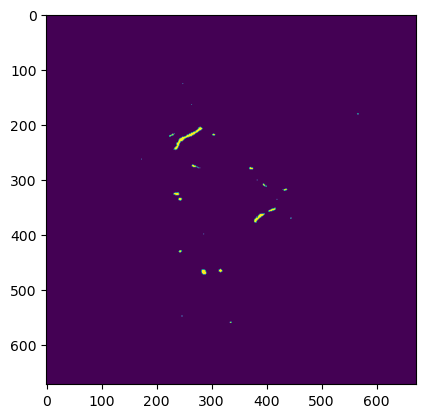

In [37]:
plt.imshow(img_seg_pr[:,:,117])

### Adaptive filtering -  Playground

In [42]:
def read_classes_from_nrrd(path):
    data, header = nrrd.read(path)
    segment_keys = {}
    for key in header.keys():
        if key.startswith('Segment') and key[7].isdigit():
            segid, cont = key.split('_')
            index = int(segid[7:])
            if index not in segment_keys.keys():
                segment_keys[index] = {}
            segment_keys[index][cont] = header[key]

    label_list = pd.DataFrame.from_dict(segment_keys, orient='index')
    label_list = label_list[['Name', 'LabelValue']].astype({'LabelValue':int}).sort_values(by=['LabelValue'])
    label_list = label_list
    return label_list.rename(columns={'Name':'name', 'LabelValue':'label id'})

In [48]:
path_to_class_labels_table = '/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/class_labels.xlsx'
class_table = pd.read_excel(path_to_class_labels_table)

In [49]:
class_table

,label id,name
0,1,ICA
1,2,VA
2,3,BA
3,4,Aneurysm
4,5,MCA-M1
5,6,MCA-M2
6,7,MCA-M3
7,8,ACA-A1
8,9,ACA-A2
9,10,ACA-A3


In [58]:
# differences between different segmentation images
path                     = "/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated"
name_of_image_segm_nrrd  = "10600633-AComm-new-Colors/Segmentation.nrrd"
name_of_image_segm_nrrd2 = "10600633-AComm-new-Colors/Segmentation-label.nrrd"
name_of_image_segm_nii   = "10600633-AComm-new-Colors/10600633-acomm-new-colors_tof.nii.gz"
name_of_image_segm2_nii  = "10600633-AComm-new-Colors/Segmentation.nii"

In [59]:
img_init_nrrd, t_nrrd   = nrrd.read(os.path.join(path, name_of_image_segm_nrrd))
img_init_nrrd2, t_nrrd2 = nrrd.read(os.path.join(path, name_of_image_segm_nrrd2))
img_seg_nii             = nib.load(os.path.join(path, name_of_image_segm_nii))
img_seg_nii_data        = img_seg_nii.get_fdata()
img_seg_nii2            = nib.load(os.path.join(path, name_of_image_segm2_nii))
img_seg_nii_data2       = img_seg_nii2.get_fdata()

In [61]:
t_nrrd['space directions']

array([[ 0.39029729, -0.00552414, -0.01434553],
       [ 0.00081676,  0.37144537, -0.12081375],
       [-0.02751016, -0.21629055, -0.6651775 ]])

In [62]:
t_nrrd2['space directions']

array([[ 0.39029729, -0.00552414, -0.01434553],
       [ 0.00081676,  0.37144537, -0.12081375],
       [-0.02751016, -0.21629055, -0.6651775 ]])

In [63]:
img_seg_nii.affine

array([[-3.90297294e-01,  8.16756336e-04, -2.75076926e-02,
         1.02339638e+02],
       [ 5.52413845e-03,  3.71445358e-01, -2.16292307e-01,
        -8.37415848e+01],
       [-1.43455267e-02,  1.20813750e-01,  6.65177643e-01,
        -1.14749130e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [64]:
img_seg_nii2.affine

array([[-3.90297293e-01, -8.16720027e-04,  2.75101490e-02,
         9.88234024e+01],
       [ 5.52410027e-03, -3.71445362e-01,  2.16290546e-01,
         7.51371994e+01],
       [-1.43455339e-02, -1.20813754e-01, -6.65177476e-01,
         4.21071014e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [41]:
t_nrrd2['space directions']

array([[ 0.38829739, -0.03649423, -0.02193627],
       [ 0.04081547,  0.37634076,  0.09638266],
       [ 0.01863098, -0.15068225,  0.58047205]])

In [42]:
t_nrrd['space directions']

array([[ 0.38829739, -0.03649423, -0.02193627],
       [ 0.04081547,  0.37634076,  0.09638266],
       [ 0.01863098, -0.15068225,  0.58047205]])

In [45]:
label_list = read_classes_from_nrrd(os.path.join(path, name_of_image_segm_nrrd))

In [46]:
label_list

,name,label id
0,CA,1
1,VA,2
2,BA,3
4,MCA_M1,4
5,MCA_M2,5
6,MCA_M3,6
7,ACA_A1,7
8,ACA_A2,8
9,ACA_A3,9
3,Aneurysm,10


In [50]:
from difflib import SequenceMatcher
def match_labels(color_table, class_table):
    mapping = {}
    i = 0
    js = list(range(class_table.shape[0]))
    matches_ratio = []
    
    while len(js) != 0 and i < color_table.shape[0]:
        matches = [SequenceMatcher(None, class_table['name'].iloc[j], color_table['name'].iloc[i]).ratio() for j in js]
        j = js[matches.index(max(matches))]
        mapping[j] = [class_table['label id'].iloc[j],color_table['label id'].iloc[i] ,class_table['name'].iloc[j], color_table['name'].iloc[i]]
        i = i+1
        js.remove(j)
        matches_ratio.append(max(matches))
        
    if np.mean(matches_ratio) < 0.75:
        print('Warning: Mapping did not work correctly', np.mean(matches_ratio))
        
    for j in js:
        mapping[j] = [j, None, class_table['name'][j], None]
        
    return mapping


In [51]:
match_labels(label_list, class_table)

{0: [1, 1, 'ICA', 'CA'],
 1: [2, 2, 'VA', 'VA'],
 2: [3, 3, 'BA', 'BA'],
 4: [5, 4, 'MCA-M1', 'MCA_M1'],
 5: [6, 5, 'MCA-M2', 'MCA_M2'],
 6: [7, 6, 'MCA-M3', 'MCA_M3'],
 7: [8, 7, 'ACA-A1', 'ACA_A1'],
 8: [9, 8, 'ACA-A2', 'ACA_A2'],
 9: [10, 9, 'ACA-A3', 'ACA_A3'],
 3: [4, 10, 'Aneurysm', 'Aneurysm'],
 12: [13, 11, 'PICA', 'PICA'],
 13: [14, 12, 'AICA', 'AICA'],
 14: [15, 13, 'SCA', 'SCA'],
 15: [16, 14, 'PCA-P1', 'PCA_P1'],
 16: [17, 15, 'PCA-P2', 'PCA_P2'],
 17: [18, 16, 'PCA-P3', 'PCA_P3'],
 18: [19, 17, 'Ophthalmic', 'Ophthlamic'],
 10: [10, None, 'AComm', None],
 11: [11, None, 'PComm', None],
 19: [19, None, 'Fetal-PCA', None],
 20: [20, None, 'Choroidea', None]}

In [637]:
mri_file_seg  = os.path.join(path, name_of_image_segm)
mri_file_init = os.path.join(path, name_of_image)
img_init, _   = nrrd.read(mri_file_init)
img_seg       = nib.load(mri_file_seg)
img_seg_data  = img_seg.get_fdata()

In [638]:
old_min = np.min(img_init)
old_max = np.max(img_init)
new_min = 0
new_max = 255
# cv needs the values to be in the range of 0-255
img_tr  = (new_max - new_min) * ((img_init - old_min)/(old_max - old_min)) + new_min
u8      = img_init.astype(np.uint8)

In [639]:
# test cv adaptive threshold
slice  = 117
thres1 = cv.adaptiveThreshold(u8[:, :, slice], 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV, 5, 20)
thres2 = cv.adaptiveThreshold(u8[:, :, slice], 255, cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV, 3, 5)

dice metric 0.13108399138549892
dice metric 0.04176369536171025


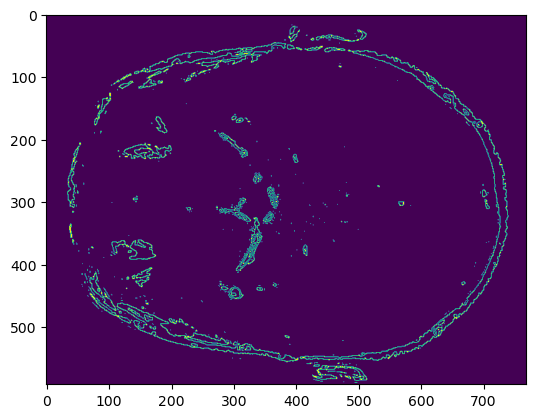

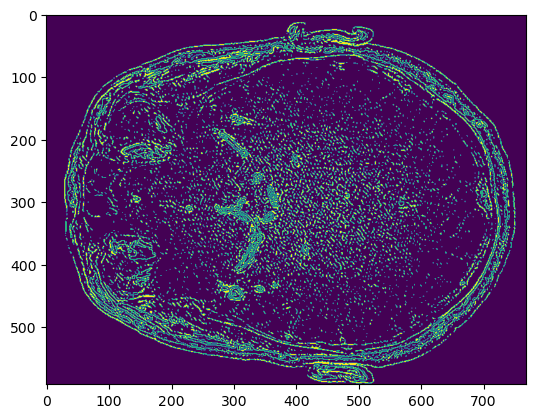

In [640]:
print("dice metric", dice_metric(binarize(thres1, 255), binarize(img_seg_data[:,:,117],1)))
print("dice metric", dice_metric(binarize(thres2, 255), binarize(img_seg_data[:,:,117],1)))
plt.figure()
plt.imshow(thres1)
plt.figure()
plt.imshow(thres2)

In [641]:
# test skimage threshold functions, which doesn't demand specific range of values

In [642]:
thres_local = ski.filters.threshold_local(img_init[:,:,slice], block_size = 3, method = "mean", offset = 5)
binary_img  = img_init[:,:,117] <= thres_local 

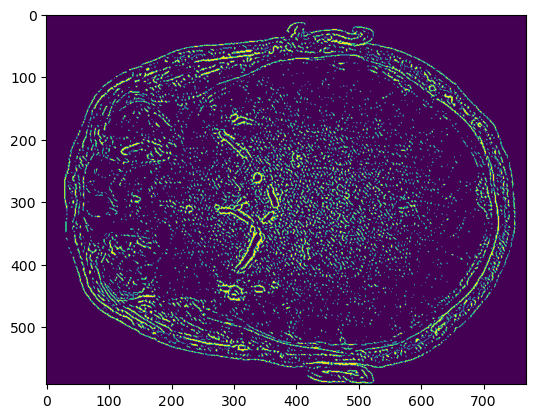

In [643]:
plt.imshow(binary_img)

In [114]:
frangiresult = ski.filters.frangi(ski.util.invert(img_init_sm_1[:,:,1]), scale_range=(4, 5), black_ridges=True)

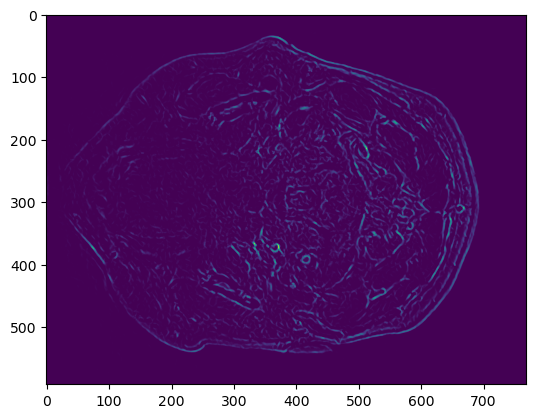

In [115]:
plt.imshow(frangiresult)

In [400]:
img_mask_t = np.where(img_mask < 1, 0, 1)
u8         = img_mask_t.astype(np.uint8)

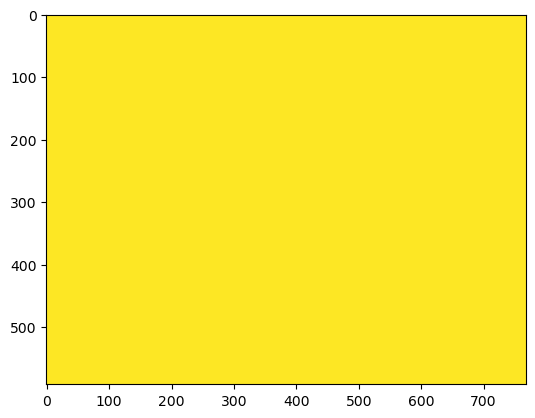

In [401]:
plt.imshow(img_mask_t[:,:,117])

In [251]:
ret, markers = cv.connectedComponents(u8[:,:,117])

In [252]:
marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 

In [253]:
largest_component = np.argmax(marker_area)+1

In [254]:
brain_mask = markers==largest_component

brain_out = img_mask_t[:,:,117].copy()
brain_out[brain_mask==False] = 0

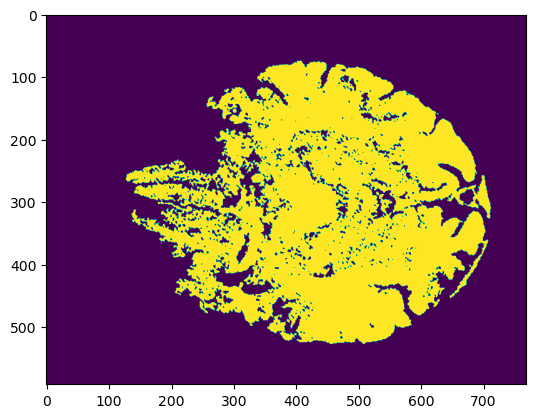

In [255]:
plt.imshow(brain_out)

In [256]:
img_mask_t =  img_mask_t[:,:,117] - brain_out

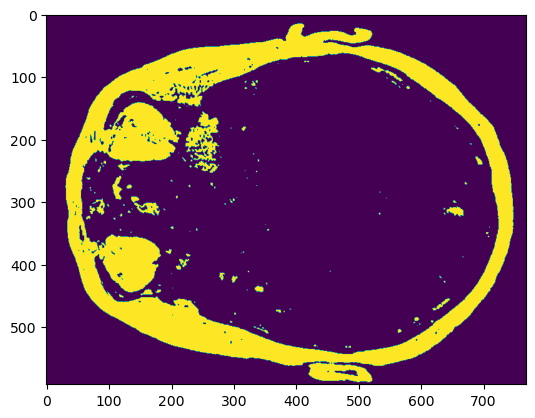

In [257]:
plt.imshow(img_mask_t)

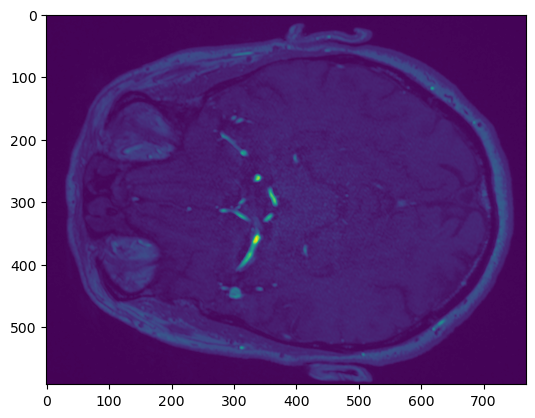

In [217]:
plt.imshow(img_init[:,:,117])


In [173]:
mri_file_seg  = os.path.join(path, name_of_image_segm)
mri_file_init = os.path.join(path, name_of_image)
img_init, _   = nrrd.read(mri_file_init)
img_seg       = nib.load(mri_file_seg)
img_seg_data  = img_seg.get_fdata()

In [174]:
# second smoothed version of the initial image
sigma         = 1
img_init_sm_1 = ndi.gaussian_filter(img_init, sigma) 

In [175]:
elevation_map = ski.filters.sobel(img_init_sm_1[:,:,117])

In [176]:
lower_bound   = np.percentile(img_init_sm_1, 50)
upper_bound   = np.percentile(img_init_sm_1, 99)
markers       = np.zeros_like(img_init_sm_1[:,:,117])
markers[img_init_sm_1[:,:,117] < lower_bound] = 1
markers[img_init_sm_1[:,:,117] > upper_bound] = 10
segmentation  = ski.segmentation.watershed(elevation_map, markers) 

In [154]:
img_init_sm_1[segmentation == 1,117] = 0

In [179]:
mask = np.ndarray.copy(img_init_sm_1)
lower_bound   = np.percentile(img_init_sm_1, 50)
upper_bound   = np.percentile(img_init_sm_1, 99)
for slice in range(img_init_sm_1.shape[-1]):
    elevation_map = ski.filters.sobel(img_init_sm_1[:,:,slice])
    markers = np.zeros_like(img_init_sm_1[:,:,slice])
    markers[img_init_sm_1[:,:,slice] < lower_bound] = 1
    markers[img_init_sm_1[:,:,slice] > upper_bound] = 10
    segmentation  = ski.segmentation.watershed(elevation_map, markers)
    mask[segmentation == 1, slice] = 0

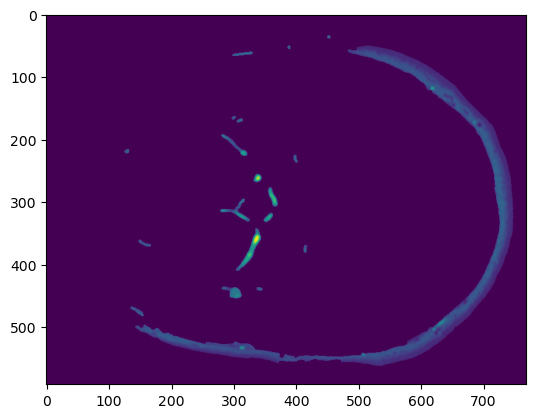

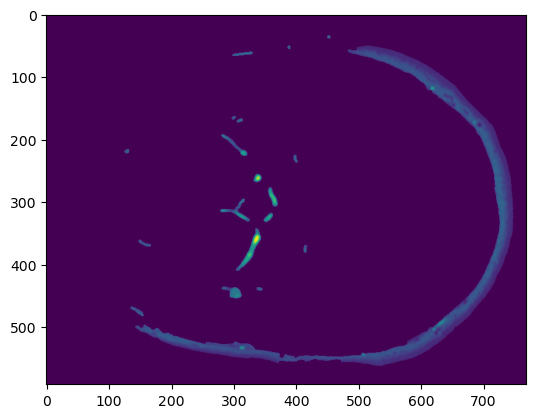

In [170]:
plt.imshow(img_init_sm_1[:,:,117])

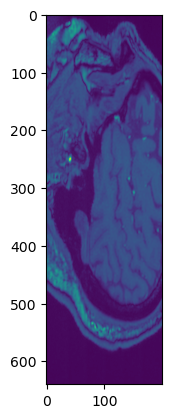

In [8]:
plt.imshow(img_init[117,:,:])

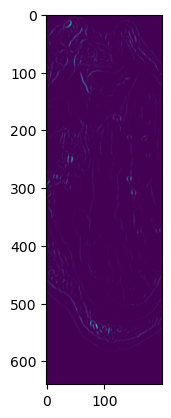

In [5]:
test = ski.filters.frangi(img_init[117,:,:])
plt.imshow(test)

In [9]:
img_init.shape

(560, 640, 200)

In [7]:
test.shape

(640, 200)

In [159]:
thresh = ski.filters.threshold_otsu(test)
binary = test > thresh

In [162]:
edges = ski.feature.canny(binary/np.max(binary))

In [163]:
fill_coins = ndi.binary_fill_holes(edges)

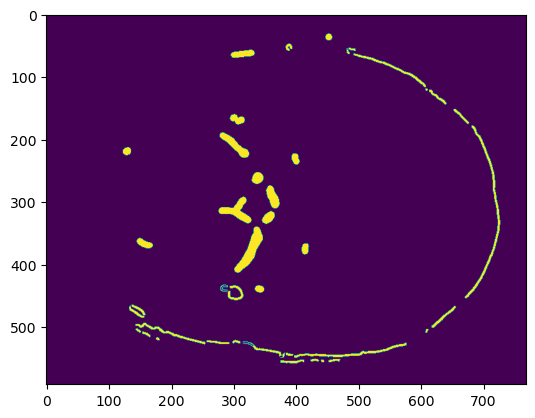

In [164]:
plt.imshow(fill_coins)

In [39]:
dataset_dict[46]

{'nrrd': '/usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ_BrainArtery/10480878_HS_PComm_MCA/7 TOF_3D_R5.nrrd',
 'nii': '/usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ_BrainArtery/10480878_HS_PComm_MCA/Segmentation_2.nii',
 'pro_nrrd': '/scratch-second/kvergopoulos/processed_data/10480878_HS_PComm_MCA/7 TOF_3D_R5.nrrd'}

In [65]:
############### afine matrices test

In [165]:
path                     = "/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/10600633-AComm-new-Colors"
#name_of_image_nrrd       = "5 Ax 3D TOF.nrrd"
name_of_image_nii        = "10015183-mca-new_tof.nii.gz"
name_of_segm_nii         = "Segmentation.nii"
name_of_segm_nrrd        = "Segmentation-label.nrrd"
#name_of_segm_nrrd2       = "Segmentation-label.nrrd"

In [166]:
#img_nrrd, t_nrrd        = nrrd.read(os.path.join(path, name_of_image_nrrd ))
img_nii                 = nib.load(os.path.join(path, name_of_image_nii))
img_nii_data            = img_nii.get_fdata()
img_seg_nii             = nib.load(os.path.join(path, name_of_segm_nii))
img_seg_nii_data        = img_seg_nii.get_fdata()
img_seg_nrrd, seg_nrrd  = nrrd.read(os.path.join(path, name_of_segm_nrrd))
#img_seg_nrrd2, seg_nrrd2= nrrd.read(os.path.join(path, name_of_segm_nrrd2))

In [169]:
for k in img_nii.header:
    print(k, img_nii.header[k], img_seg_nii.header[k])

sizeof_hdr 348 348
data_type b'' b''
db_name b'' b''
extents 0 0
session_error 0 0
regular b'' b'r'
dim_info 0 0
dim [  3 512 512 176   1   1   1   1] [  3 512 512 176   1   1   1   1]
intent_p1 0.0 0.0
intent_p2 0.0 0.0
intent_p3 0.0 0.0
intent_code 0 0
datatype 16 4
bitpix 32 16
slice_start 0 0
pixdim [-1.          0.390625    0.390625    0.59999985  1.          1.
  1.          1.        ] [1.       0.390625 0.390625 0.6      0.       0.       0.       0.      ]
vox_offset 0.0 0.0
scl_slope nan nan
scl_inter nan nan
slice_end 0 0
slice_code 0 0
xyzt_units 2 2
cal_max 0.0 0.0
cal_min 0.0 0.0
slice_duration 0.0 0.0
toffset 0.0 0.0
glmax 0 0
glmin 0 0
descrip b'' b''
aux_file b'' b''
qform_code 0 1
sform_code 2 0
quatern_b 0.058346972 -0.027124934
quatern_c -0.99739236 0.032686476
quatern_d -0.03268651 -0.9973923
qoffset_x 111.24645 88.36794
qoffset_y -66.24357 131.5802
qoffset_z -80.3236 -66.67675
srow_x [-3.8739052e-01 -4.4772036e-02  3.4753613e-02  1.1124645e+02] [0. 0. 0. 0.]
srow_

In [184]:
new_img = img_nii.__class__(t, img_nii.affine, img_nii.header)

In [185]:
new_img.to_filename('/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/10015183-MCA-new/test7.nii.gz')

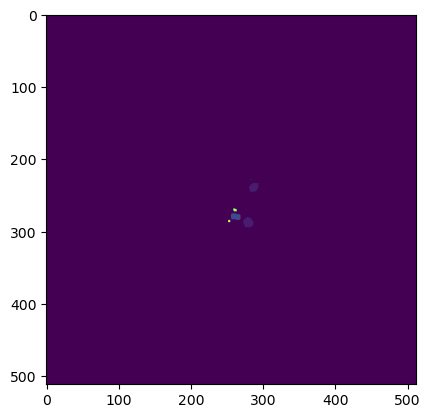

In [182]:
t = np.flip(img_seg_nii_data, axis=1)
plt.imshow(t[:,:,52])

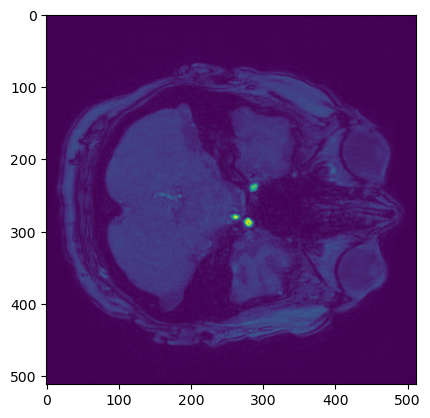

In [177]:
plt.imshow(img_nii_data[:,:,52])

In [33]:
path1_init = "/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/10797356-VA-NEW/10797356-va-new_tof.nii.gz"
path1_seg  = "/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/10797356-VA-NEW/10797356-va-new_corrected_Segmentation.nii" 

In [34]:
img_nii_1init = nib.load(path1_init)
img_nii_1seg  = nib.load(path1_seg)


In [35]:
path2_init = "/scratch/kvergopoulos/SemesterProject/datasets/n4_corrected/10797356-va-new_n4_corr.nii.gz"
path2_seg  = "/scratch/kvergopoulos/SemesterProject/datasets/n4_corrected/10797356-va-new_seg.nii.gz" 

In [36]:
img_nii_2init = nib.load(path2_init)
img_nii_2seg  = nib.load(path2_seg)


In [37]:
np.testing.assert_almost_equal(img_nii_2init.get_fdata(), img_nii_1init.get_fdata(), decimal=3, err_msg = 'deviation < 6th decimal')

AssertionError: 
Arrays are not almost equal to 3 decimals
deviation < 6th decimal
Mismatched elements: 51302043 / 64870400 (79.1%)
Max absolute difference: 0.0070863
Max relative difference: 0.0017446
 x: array([[[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],...
 y: array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],...

In [38]:
np.testing.assert_almost_equal(img_nii_2seg.get_fdata(), img_nii_1seg.get_fdata(), decimal=6, err_msg = 'deviation < 6th decimal')

AssertionError: 
Arrays are not almost equal to 6 decimals
deviation < 6th decimal
Mismatched elements: 224964 / 64870400 (0.347%)
Max absolute difference: 0.00013733
Max relative difference: 6.10363204e-05
 x: array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],...
 y: memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],...

In [39]:
np.max(img_nii_2init.get_fdata()-img_nii_1init.get_fdata())

0.007070824503898621

In [24]:
np.where(img_nii_2init.get_fdata()-img_nii_1init.get_fdata() == 0.016867659986019135)

(array([ 75, 105, 134, 134, 135, 135, 144, 144, 166, 168, 168, 170, 182,
        185, 189, 190, 191, 196, 203, 207, 209, 211, 214, 214, 215, 218,
        220, 220, 221, 222, 223, 226, 230, 231, 231, 255, 256, 259, 262,
        263, 263, 277, 283, 284, 285, 285, 285, 286, 286, 286, 288, 288,
        289, 292, 293, 298, 307, 309, 317, 318, 329, 363, 377, 409, 433,
        436, 442, 443]),
 array([243, 267, 278, 282, 284, 359, 312, 312, 347, 193, 340, 201, 279,
        279, 269, 278, 263, 208, 218, 257, 293, 219, 249, 253, 252, 252,
        218, 225, 225, 231, 245, 208, 212, 210, 212, 284, 279, 133, 173,
        178, 304, 327, 233, 209, 218, 222, 248, 213, 226, 231, 221, 226,
        220, 223, 205, 269, 220, 255, 281, 282, 286, 334, 284, 274, 270,
        226, 247, 253]),
 array([ 72,  41,  18,  13,  16,  42,  18,  23,  25,  99,  24,  97,  58,
         12,  61,  16,  65,  99,  98,  59, 110, 100,  60,  63,  63,  59,
         79,  80,  80,  94,  66,  80,  85,  83,  83,  53,  59, 132, 120,
 

In [40]:
print(img_nii_2init.get_fdata()[105,267,41],img_nii_1init.get_fdata()[105,267,41])

62.99650463461876 63.0


In [ ]:
# resunt no multithreading all data, no anything
Dice scores:  0.25882578639695675 0.053579005688654494 0.150595494911056 0.40109108076445593
Recall scores:  0.8640905520827893 0.05835533302296929 0.661084448683936 0.9667523384451558

In [2]:
path_to_n4_corr = '/scratch/kvergopoulos/SemesterProject/datasets/n4_corrected'
path_to_logbias = '/scratch/kvergopoulos/SemesterProject/intermediate_results/n4_log_bias' 

In [5]:
subject_name  = '02053152-mca-rechts-new_tof.nii.gz'
log_bias_name = 'n4_bias_02053152-mca-rechts-new.npy'

In [6]:
log_bias_field = np.load(os.path.join(path_to_logbias, log_bias_name))
img_           = nib.load(os.path.join(path_to_n4_corr, subject_name))

(<matplotlib.image.AxesImage at 0x7fc2ec97e440>,
 <matplotlib.colorbar.Colorbar at 0x7fc2ec827ca0>)

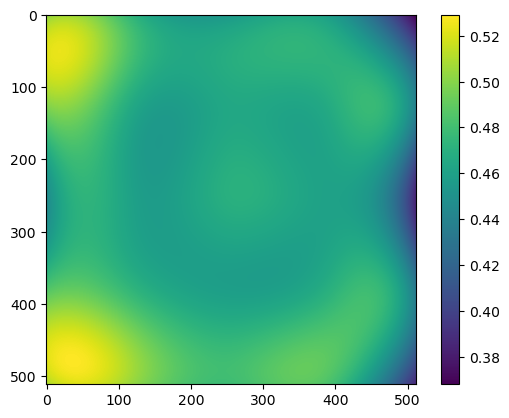

In [7]:
plt.imshow(log_bias_field[:,:,76]), plt.colorbar()

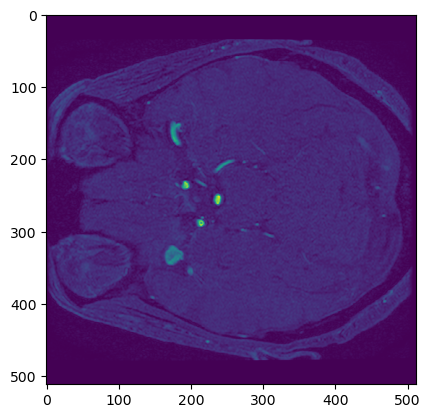

In [11]:
plt.imshow(img_.get_fdata()[:,:,76])

In [1]:
path_to_skull_stripped = '/scratch/kvergopoulos/SemesterProject/datasets/skull_stripped'

In [8]:
subject_name = '60213089-mca-ica-new_tof.nii.gz'
segm         = '60213089-mca-ica-new_seg_real.nii.gz'

In [6]:
img_           = nib.load(os.path.join(path_to_skull_stripped, subject_name))

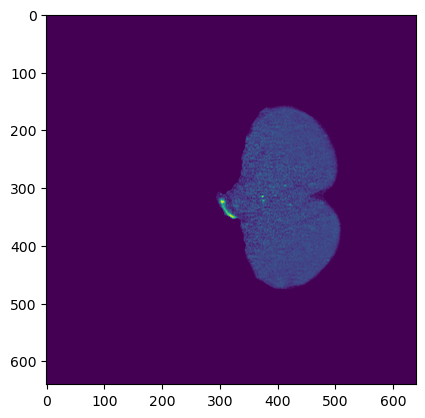

In [7]:
plt.imshow(img_.get_fdata()[:,:,76])

In [9]:
segm_img = nib.load(os.path.join(path_to_skull_stripped, segm))

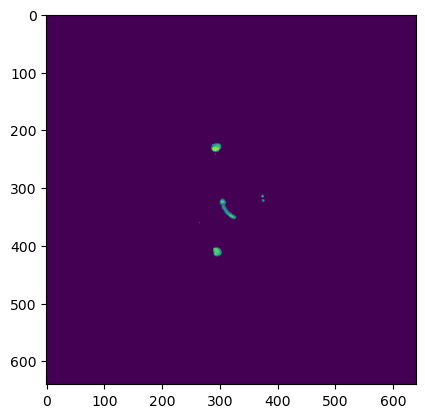

In [10]:
plt.imshow(segm_img.get_fdata()[:,:,76])